<a href="https://colab.research.google.com/github/ashishpatel26/Covid19-tweet-sentimental-Analysis/blob/main/Transformer_for_Covid19_Tweet_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Transformer

In [1]:
!pip install transformers

### **1.Load Framewoorks**

In [40]:
import re
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

# Data Reading
import torch
from torch.utils.data import TensorDataset

# NLP Task
import transformers
from transformers import BertTokenizer
from transformers import BertForSequenceClassification

# Define Seed
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device = torch.device('cuda')

### **2.Read dataset**

In [3]:
train = pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Covid19-tweet-sentimental-Analysis/main/data/Corona_NLP_train.csv", encoding='latin-1')
test = pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Covid19-tweet-sentimental-Analysis/main/data/Corona_NLP_test.csv", encoding='latin-1')
print("--Train Data--")
display(train.head())
print("--Test Data--")
display(test.head())

--Train Data--


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


--Test Data--


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


### **3.Data Preprocessing**

##### **1.Mention and Hashtag**

In [4]:
class MentionHastag():
  '''
  Extract the Mention and HashTag  
  '''
  def __init__(self, text = None):
    self._text = text

  def extractHashTag(self, text = None):
    if text:
      self.hashtag = re.findall(r'#(\w+)', text)
      return " ".join(self.hashtag)
    else:
      self.hashtag = re.findall(r'#(\w)', self._text)
      return " ".join(self.hashtag)

  def extractMentions(self, text = None):
    if text:
      self.mention = re.findall(r'@(\w+)', text)
      return " ".join(self.mention)
    else:
      self.mention = re.findall(r'@(\w)', self._text)
      return " ".join(self.mention)

In [5]:
menhas = MentionHastag()

In [6]:
train['hashtags'] = train['OriginalTweet'].apply(lambda x : menhas.extractHashTag(text=x))
train['mensions'] = train['OriginalTweet'].apply(lambda x : menhas.extractMentions(text=x))

test['hashtags'] = test['OriginalTweet'].apply(lambda x : menhas.extractHashTag(text=x))
test['mensions'] = test['OriginalTweet'].apply(lambda x : menhas.extractMentions(text=x))

In [7]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,hashtags,mensions
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,MeNyrbie Phil_Gahan Chrisitv
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,,
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,,
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,COVID19france COVID_19 COVID19 coronavirus con...,
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,COVID19 coronavirus CoronavirusFrance restezch...,


In [8]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,hashtags,mensions
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,coronavirus,
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,Amazon coronavirus,
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,coronavirus,
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,Panic NewYork healthcare BigApple coronavirus ...,
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,toiletpaper dunnypaper coronavirus coronavirus...,


##### **2.Encoding Class**




In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [10]:
train["encoded_sentiments"] = le.fit_transform(train["Sentiment"])
test["encoded_sentiments"] = le.fit_transform(test["Sentiment"])

##### **3.Removing  Special Characters**

In [11]:
train["OriginalTweet"] = train["OriginalTweet"].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)| \
                                                                                ([^0-9A-Za-z \t])| \
                                                                                (\w+:\/\/\S+)"," ",x) \
                                                                                .split())) 
test["OriginalTweet"] = test["OriginalTweet"].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)| \
                                                                                ([^0-9A-Za-z \t])| \
                                                                                (\w+:\/\/\S+)"," ",x) \
                                                                                .split()))

### **4. Train Test Split**

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train["OriginalTweet"], train["encoded_sentiments"], test_size = 0.2)

for name, var in zip(['X_train', 'X_val', 'y_train', 'y_val'], [X_train, X_val, y_train, y_val]):
  print(f"{name} shape : {var.shape}")

X_train shape : (32925,)
X_val shape : (8232,)
y_train shape : (32925,)
y_val shape : (8232,)


### **5. Bert Tokenizer**

In [14]:
bert_tn = transformers.BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [16]:
encoding_train_data = bert_tn.batch_encode_plus(X_train,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                padding=True,
                                                max_length = 50, 
                                                truncation=True,
                                                return_tensors='pt')
encoding_val_data = bert_tn.batch_encode_plus(X_val,
                                              add_special_tokens = True,
                                              return_attention_mask = True,
                                              padding=True,
                                              max_length = 50,
                                              truncation=True,
                                              return_tensors='pt')

In [20]:
from pprint import pprint
pprint(encoding_train_data)

{'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[  101,  2182,  3022,  ..., 16770,  1024,   102],
        [  101,  2070,  2752,  ...,     0,     0,     0],
        [  101,  1996, 12702,  ...,     0,     0,     0],
        ...,
        [  101,  2306,  1037,  ...,  7712,  1001,   102],
        [  101,  1029,  1029,  ...,  2010,  5958,   102],
        [  101, 13025,  3573,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])}


### **6.Visualize the tokenise data**

In [27]:
for i in ['attention_mask','input_ids','token_type_ids']:
  print(f">>>---Tensor of {i}")
  display(pd.DataFrame(encoding_train_data[i].numpy()))

>>>---Tensor of attention_mask


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32920,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
32921,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
32922,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
32923,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


>>>---Tensor of input_ids


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,101,2182,3022,1037,6302,2013,4174,2073,2111,6023,2024,2108,6380,21529,6067,2138,2122,2024,2025,29347,14416,20925,2050,5350,1012,1045,2228,2023,2003,2054,2561,25691,2964,3504,2066,1999,2049,2220,5711,1012,1001,21887,23350,1001,2522,17258,16147,16770,1024,102
1,101,2070,2752,1997,4361,2024,2200,18636,2005,3784,13025,6023,2066,7473,4671,1001,2522,17258,1035,2539,1001,3784,1001,2833,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,101,1996,12702,2015,1999,2026,2181,1997,2024,2725,3599,2008,1998,2024,2128,9331,2075,1996,19054,2302,3976,21857,2015,2030,2151,2060,26136,13043,3424,7325,5468,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,101,1045,2005,2028,2123,1005,1056,2228,6634,9343,2003,4072,2138,2028,2097,2203,2039,8840,18606,2035,2037,2833,2349,2000,7170,21146,4667,2061,2009,2003,2061,2025,4072,1012,1001,21887,23350,2003,22308,2007,2256,4641,102,0,0,0,0,0,0,0
4,101,2235,5661,1999,2710,2215,2019,1005,5057,3293,9278,4335,2565,1005,2096,1996,2924,1997,2710,1998,4642,16257,1999,10258,3686,2613,3776,7597,2000,4337,2522,17258,1011,2539,16770,1024,1013,1013,1056,1012,2522,1013,1054,2487,2361,2620,2595,2581,26291,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32920,101,2047,2265,1024,2012,14844,2298,2066,22017,5910,2050,7832,1024,8292,2571,2497,1001,21887,23350,7928,1010,17006,7357,1010,1001,8870,5302,13469,8273,4779,4920,2050,2713,1010,5365,2188,11058,1010,1001,2047,9028,9488,2869,19237,1029,4942,1013,21469,1006,102
32921,101,1999,8780,2015,8704,2000,3143,2048,2192,2624,25090,6290,4264,1999,1996,2866,1998,2762,1999,2184,2420,2000,3965,1015,2213,11015,2566,3204,2169,2000,4769,1037,4187,15843,2408,2885,102,0,0,0,0,0,0,0,0,0,0,0,0,0
32922,101,2306,1037,2733,1010,9871,11670,1010,4744,6853,1998,13025,3573,5126,2150,2062,2590,2008,3297,2111,1001,12609,1001,18402,1001,21887,23350,1001,2522,17258,16147,1001,21887,23350,5833,23890,1001,21887,6873,25778,22571,3366,1001,21887,23350,9739,3207,7712,1001,102
32923,101,1029,1029,2040,11923,1012,3504,2066,2057,2179,1008,2178,1008,5205,2040,1000,3402,1000,14019,2010,4518,9583,2157,2044,1037,2797,27918,2006,1001,21887,23350,1012,5205,2853,2039,2000,1002,3156,1010,2199,1997,2010,4518,2006,1996,6928,2044,2010,5958,102


>>>---Tensor of token_type_ids


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32920,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32921,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32922,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32923,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **7.Extract the Encoded data**

In [29]:
train_input_ids = encoding_train_data['input_ids']
train_attention_masks = encoding_train_data['attention_mask']
train_labels = torch.tensor(y_train.values)


val_input_ids = encoding_val_data['input_ids']
val_attention_masks = encoding_val_data['attention_mask']
val_labels = torch.tensor(y_val.values)

### **8.Convert Pytorch Tensor Dataset Format**

In [56]:
# Pytorch TensorDataset Instance
ds_train = TensorDataset(train_input_ids, train_attention_masks, train_labels)
ds_Val = TensorDataset(val_input_ids, val_attention_masks, val_labels)

### **9.Bert Model Initialization**

In [34]:
bert = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                                  num_labels=5,
                                                                  output_attentions=False,
                                                                  output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### **10.DataLoader**

In [57]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dl =  DataLoader(ds_train, sampler = RandomSampler(ds_train), batch_size=128)
val_dl =  DataLoader(ds_Val, sampler = RandomSampler(ds_Val), batch_size=128)

### **11.Model Optimization**

In [38]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(bert.parameters(), lr= 1e-5, eps = 1e-8)
epochs = 5
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dl))

### **12.Metrics**

In [61]:
from sklearn.metrics import f1_score

def f1_score_fn(actual, predicted):
  preds = np.argmax(predicted, axis=1).flatten()
  labels = actual.flatten()
  return f1_score(labels, preds, average='weighted')

### 13.Model Training

In [41]:
bert.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [49]:
for epoch in tqdm(range(1, epochs+1)):
  
  # Model training
  bert.train()

  # loss count
  train_loss_total = 0

  # progress bar
  progress_bar = tqdm(train_dl, desc=f'Epoch {epoch:1d}', leave = False, disable = False)

  # Epochs
  tqdm.write(f'\nEpoch {epoch}')

  for batch in progress_bar:

    # make model gradient reset
    bert.zero_grad()

    # inputs
    inputs = {
              'input_ids' : batch[0].to(device),
              'attention_mask' : batch[1].to(device),
              'labels' : batch[2].to(device)
              } 

    # outputs
    outputs = bert(**inputs)

    loss = outputs[0]
    train_loss_total += loss.item()

    # Backward propagation
    loss.backward()

    # clip the gradient
    torch.nn.utils.clip_grad_norm_(bert.parameters(), 1.0)

    # optimization bert
    optimizer.step()

    # scheduler
    scheduler.step()

    progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    

    train_loss_avg = train_loss_total/len(train_dl)

  tqdm.write(f'Training loss: {train_loss_avg}')

Training loss: 1.3144335746765137


Training loss: 1.1967255902844807


Training loss: 1.197342760341112


Training loss: 1.1972413206285284


Training loss: 1.1965538646823677



### **14.Model Evaluation**

In [58]:
def evaluate(val_dl):

  bert.eval()
  
  total_val_loss = 0
  predictions, true_vals = [], []
  
  for batch in val_dl:
      
      batch = tuple(b.to(device) for b in batch)
      
      inputs ={
                'input_ids':      batch[0],
                'attention_mask': batch[1],
                'labels':         batch[2]
              }

      with torch.no_grad():        
          outputs = bert(**inputs)
          
      loss = outputs[0]
      logits = outputs[1]
      total_val_loss += loss.item()

      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)
  
  val_avg_loss = total_val_loss/len(val_dl) 
  
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
          
  return val_avg_loss, predictions, true_vals

In [60]:
val_loss, predictions, true_vals = evaluate(val_dl = val_dl)

In [63]:
val_f1 = f1_score_fn(true_vals, predictions)
print('Validation Loss = ', val_loss)
print('Validiation F1 = ', val_f1)

Validation Loss =  1.1935951618047862
Validiation F1 =  0.5040421392615076


### **15.Evalution Result**

In [65]:
encoded_classes = le.classes_
predicted_category = [encoded_classes[np.argmax(x)] for x in predictions]
true_category = [encoded_classes[x] for x in true_vals]

In [66]:
x = 0
for i in range(len(true_category)):
    if true_category[i] == predicted_category[i]:
        x += 1
        
print('Accuracy Score = ', x / len(true_category))

Accuracy Score =  0.5042517006802721


In [67]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_true = true_category, y_pred = predicted_category, labels=list(encoded_classes))

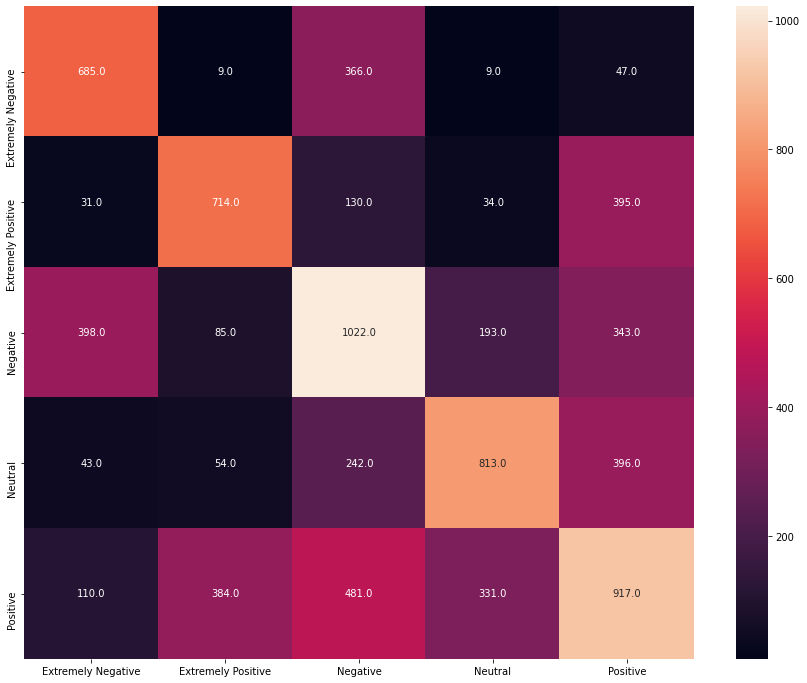

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,12))
df = pd.DataFrame(confusion_mat, index = list(encoded_classes),columns = list(encoded_classes))
sns.heatmap(df, annot=True, fmt='.1f')
plt.show()